### Kraus objective minimization on Lindblad evolution

In [1]:
using Symbolics
using LinearAlgebra
using DynamicPolynomials

Auxilary function for square Frobenius norm of the matrix $\left\| M \right\|_F^2$:

In [2]:
function frobenius_norm2(m)
    return tr(m * m')
end

frobenius_norm2 (generic function with 1 method)

#### Consider Kraus evolution of quantum system

Consider Kraus map - a linear Completely Positive Trace Preserving (CP-TP) evolution of density matrix $\rho$:
\begin{aligned}
    \rho(t) & = \sum_{k=1}^{\ell} E_k^{} \rho(0) E_k^{\dagger}.
\end{aligned}

The operators $\{E_k \}_{k=1}^{\ell}$ are called Kraus operators and satisfy the completeness relation $\sum_{k=1}^{\ell}E_k^\dagger E_k = \mathbb{1}$ with $\ell \leq n^2-1$.

#### The corresponding minimization problem

 Terms for the objective for minimization for evolution from $\rho_{(0)}$ to $\rho_{(1)}$: 
\begin{align}
\left\| \sum_{k=1}^\ell \hat{E}_k \rho_{(0)} \hat{E}_k^{\dagger} - \rho_{(1)} \right\|_F^2
\rightarrow \operatorname{min}
\end{align} 
Under constraint:
\begin{align}
\sum_{k=1}^\ell \hat{E}_k^\dagger \hat{E}_k  = \mathbb{1}.
\end{align}

For the time series of $\rho(t)$:
\begin{align}
    \sum_{i=0}^{N-1} \left\| \sum_{k=1}^\ell \hat{E}_k \rho_{(i)} \hat{E}_k^{\dagger} - \rho_{(i+1)} \right\|_F^2 \rightarrow \operatorname{min}
\end{align}

under constrain:
\begin{align}
\left \| \sum_{k=1}^\ell \hat{E}_k^\dagger \hat{E}_k  -\mathbb{1} \right\|_F^2 = 0
\end{align}

The following function will essemble the Krauss objective from the time series of density matrix evolution:

In [85]:
import Base.real
function real(p::AbstractPolynomial)
    sum(real(coef) * mon for (coef, mon) in zip(coefficients(p), monomials(p))) #if ~isapproxzero(abs(coef)))
end
#=
function kraus(ρ)
    
    @polyvar a1[1:2, 1:2]
    @polyvar b1[1:2, 1:2]
    K1 = 1.0 * a1 + im * b1

    @polyvar a2[1:2, 1:2]
    @polyvar b2[1:2, 1:2]
    K2 = 1.0 * a2 + im * b2
    
    obj = 0
    for i in 1:length(ρ)-1
        obj += frobenius_norm2(K1 * ρ[i] * K1' + K2 * ρ[i] * K2' - ρ[i+1])
    end
    
    obj = sum(real(coef) * mon for (coef, mon) in zip(coefficients(obj), monomials(obj)))
    
    constr = frobenius_norm2(K1'*K1 + K2'*K2 - I)
    
    return real(obj), real(constr)
    #return obj, constr
    
end
=#
function kraus(ρ, K...) 
    obj = 0
    for i in 1:length(ρ)-1
        obj += frobenius_norm2(sum(k * ρ[i] * k' for k in K) - ρ[i+1])
    end
    constr = frobenius_norm2(sum(k' * k for k in K) - I)
    return real(obj), real(constr)
end

kraus (generic function with 2 methods)

Consider toy example

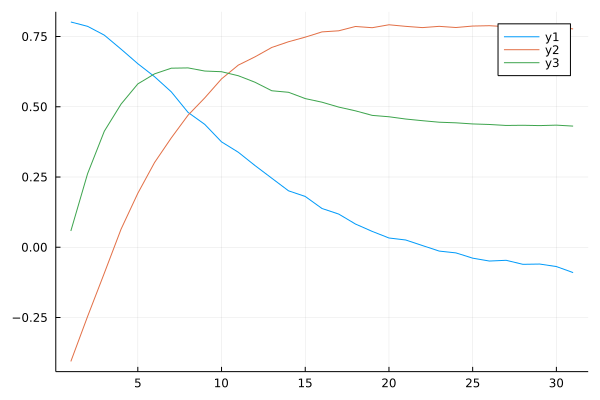

In [147]:
include("LiPoSID.jl")
seed = 100
w = 0.01
t = [0:0.01:0.3;]
ρ = LiPoSID.rand_Linblad_w_noise(seed, w, t)


using Plots
plot(LiPoSID.bloch(ρ)')

In [148]:
    @polyvar a1[1:2, 1:2]
    @polyvar b1[1:2, 1:2]
    K1 = 1.0 * a1 + im * b1

    @polyvar a2[1:2, 1:2]
    @polyvar b2[1:2, 1:2]
    K2 = 1.0 * a2 + im * b2

2×2 Matrix{Polynomial{true, ComplexF64}}:
 a2₁₋₁ + (0.0+1.0im)b2₁₋₁  a2₁₋₂ + (0.0+1.0im)b2₁₋₂
 a2₂₋₁ + (0.0+1.0im)b2₂₋₁  a2₂₋₂ + (0.0+1.0im)b2₂₋₂

In [149]:
obj, constr = kraus(ρ, K1, K2);

In [150]:
using MosekTools
using JuMP
using MomentTools

In [151]:
optimizer = optimizer_with_attributes(Mosek.Optimizer)

MathOptInterface.OptimizerWithAttributes(Mosek.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[])

In [159]:
obj_min, M = minimize(obj, [constr], [], variables(obj), 2, optimizer) 
typeof(M)

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4845            
  Cones                  : 0               
  Scalar variables       : 2               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimizat

Model

In [153]:
r = get_minimizers(M)
obj_min_vals = [obj(r[:,i]) for i=1:size(r)[2]]
best_candidate = r[:, argmin(obj_min_vals)]

16-element Vector{Float64}:
 -0.15131150541576988
 -0.030984595338018676
 -0.14845435700332318
 -0.11010450093503266
 -0.011236549642005232
 -0.029405089640672837
 -0.1890476644693564
 -0.10970366040260027
 -0.07494576844740555
 -0.006634107855031501
 -0.12213609991396501
 -0.06655641111182281
 -0.22620749042280405
 -0.008162487929718056
 -0.08320372809562879
 -0.26919043991989483

In [154]:
#variables(constr) == variables(obj)
obj(best_candidate), constr(best_candidate)

(21.44319152898814, 1.5222429202169574)

In [155]:
using NLopt

guess = -1 .+ 2 *randn(length(best_candidate))

vars = variables(obj)
    
@assert length(vars) == length(guess)

function g(a...)
    # Converting polynomial expression to function to be minimize
    obj(vars => a)
end

model = Model(NLopt.Optimizer)
#:
# LN_COBYLA
# NLOPT_
set_optimizer_attribute(model, "algorithm", :LN_COBYLA)

#set_silent(model)
@variable(model, y[1:length(vars)]);

for (var, init_val) in zip(y, guess)
    set_start_value(var, init_val)
end


function e(a...)
    # Converting polynomial expression to function to be minimize
    constr(vars => a)
end

register(model, :g, length(y), g; autodiff = true)
register(model, :e, length(y), e; autodiff = true)

@NLconstraint(model, e(y...) == 0)

@NLobjective(model, Min, g(y...))
JuMP.optimize!(model)
solution_kraus = vars => map(value, y)

subs(obj, solution_kraus), subs(constr, solution_kraus)

(1.645138038635661, 1.0746958878371515e-13)

(2.435634818391904, 4.8405723873656825e-14)

In [80]:
typeof(Hermitian(ρ[1]))

Hermitian{ComplexF64, Matrix{ComplexF64}}

In [156]:
K1_sid = convert(Matrix{ComplexF64}, subs(K1, solution_kraus))
K2_sid = convert(Matrix{ComplexF64}, subs(K2, solution_kraus))


2×2 Matrix{ComplexF64}:
 -0.314013+0.0191879im  -0.773016-0.122183im
 -0.294509+0.0397428im  -0.195299-0.216039im

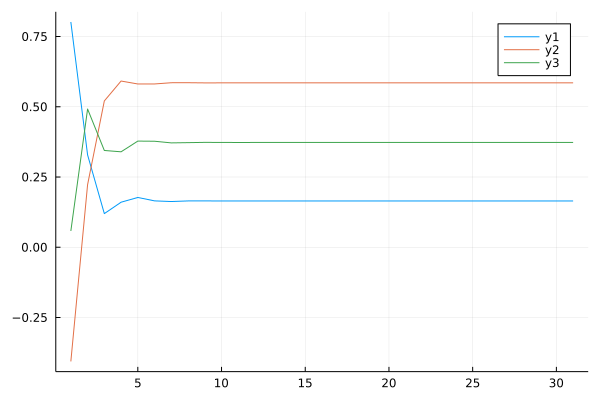

In [157]:
time_steps = length(t)
ρ_sid_kraus = LiPoSID.timeevolution_kraus(time_steps, ρ[1], [K1_sid, K2_sid])
plot(LiPoSID.bloch(ρ_sid_kraus)')

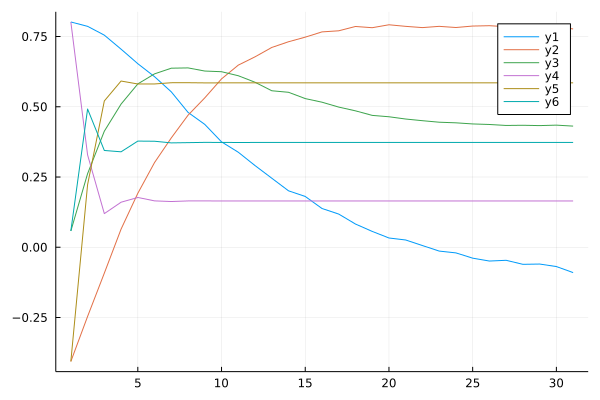

In [158]:
plot(LiPoSID.bloch(ρ)')
plot!(LiPoSID.bloch(ρ_sid_kraus)')

In [ ]:
    fidelity_kraus = min_fidelity_between_series(ρ_sid_kraus, ρ)